In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import CM4Xutils
CM4Xutils.__version__

'0.2.1'

In [3]:
import doralite
import gfdl_utils.core as gu

In [4]:
import xbudget
import xwmb

In [5]:
model = "CM4Xp25"
interval = "1850"
grid = CM4Xutils.load_wmt_grid(model, interval=interval, dmget=True)

Loading CM4Xp25-piControl for interval `1850`.
Issuing dmget command to migrate data to disk. Migration complete.
Issuing dmget command to migrate data to disk. Migration complete.
Issuing dmget command to migrate data to disk. Migration complete.
Issuing dmget command to migrate data to disk. Migration complete.
Issuing dmget command to migrate data to disk. Migration complete.
Loading CM4Xp25-historical for interval `1850`.
Issuing dmget command to migrate data to disk. Migration complete.
Issuing dmget command to migrate data to disk. Migration complete.
Issuing dmget command to migrate data to disk. Migration complete.
Issuing dmget command to migrate data to disk. Migration complete.
Issuing dmget command to migrate data to disk. Migration complete.
Overriding CM4Xp25 grid coordinates from supergrid.
Regridding ice
Inferring Z grid coordinate: depth `z_`


In [6]:
grid._ds = CM4Xutils.add_sigma2_coords(grid._ds)

In [7]:
budgets_dict = xbudget.load_preset_budget(model="MOM6_3Donly")
xbudget.collect_budgets(grid, budgets_dict)

/work/hfd/.conda/envs/CM4X/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/work/hfd/.conda/envs/CM4X/lib/python3.12/site-packages/xgcm/grid_ufunc.py:836: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [8]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    wmb = xwmb.WaterMassBudget(
        grid,
        budgets_dict,
        method="xgcm"
    )
    wmb.mass_budget("sigma2", greater_than=True, default_bins=False, integrate=True, along_section=False)
    wmt = wmb.wmt

In [9]:
%%time
wmt_mean = (wmt.sel(exp="control").mean("time")/1035*1e-6)
wmt_mean.load()

CPU times: user 1h 2min 19s, sys: 1h 2min 6s, total: 2h 4min 25s
Wall time: 24min 36s


<xarray.Dataset> Size: 69MB
Dimensions:                                         (sigma2_l_target: 74,
                                                     sigma2_i_target: 75,
                                                     time_bounds: 61, xh: 1440,
                                                     yh: 1080)
Coordinates: (12/13)
    exp                                             <U7 28B 'control'
  * sigma2_l_target                                 (sigma2_l_target) float64 592B ...
  * sigma2_i_target                                 (sigma2_i_target) float64 600B ...
  * time_bounds                                     (time_bounds) object 488B ...
  * xh                                              (xh) int64 12kB 0 1 ... 1439
  * yh                                              (yh) int64 9kB 0 1 ... 1079
    ...                                              ...
    geolon                                          (yh, xh) float64 12MB -29...
    lon                                             (yh, xh) float64 12MB -29...
    geolat                                          (yh, xh) float64 12MB -79...
    lat                                             (yh, xh) float64 12MB -79...
    deptho                                          (yh, xh) float32 6MB 0.0 ...
    wet                                             (yh, xh) float32 6MB 0.0 ...
Data variables: (12/39)
    surface_ocean_flux_advective_negative_lhs_heat  (sigma2_l_target) float64 592B ...
    surface_ocean_flux_advective_negative_lhs_salt  (sigma2_l_target) float64 592B ...
    surface_exchange_flux_heat                      (sigma2_l_target) float64 592B ...
    surface_exchange_flux_salt                      (sigma2_l_target) float64 592B ...
    frazil_ice_heat                                 (sigma2_l_target) float64 592B ...
    Eulerian_tendency_heat                          (sigma2_l_target) float64 592B ...
    ...                                              ...
    mass_tendency                                   (sigma2_l_target) float64 592B ...
    dt                                              float64 8B 0.002539
    realized_transformation                         (sigma2_l_target) float64 592B ...
    spurious_numerical_mixing                       (sigma2_l_target) float64 592B ...
    advection_plus_BC                               (sigma2_l_target) float64 592B ...
    diabatic_advection                              (sigma2_l_target) float64 592B ...

In [10]:
def stairs(wmt, var, units="kg", **kwargs):
    da = wmt[var]
    coord = wmt[[c for c in wmt.coords if "l_target" in c][0]]
    coord_bounds = wmt[[c for c in wmt.coords if "i_target" in c][0]]
    l = plt.stairs(da, coord_bounds, **kwargs, orientation="horizontal")
    plt.xlabel(f"mean transformation rate [{units}]")
    return l

(-50.0, 50.0)

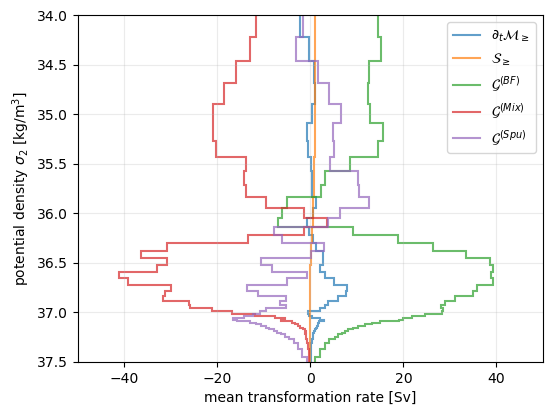

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4.5))

kwargs = {"units":"Sv", "alpha":0.7, "lw":1.5}

stairs(-wmt_mean, 'mass_tendency',             label=r"$\partial_{t} \mathcal{M}_{\geq}$",**kwargs)
stairs( wmt_mean, 'mass_source',               label=r"$\mathcal{S}_{\geq}$",            **kwargs)
stairs( wmt_mean, 'boundary_fluxes',           label=r"$\mathcal{G}^{(BF)}$",      **kwargs)
stairs( wmt_mean, 'diffusion',                 label=r"$\mathcal{G}^{(Mix)}$",     **kwargs)
stairs( wmt_mean, 'spurious_numerical_mixing', label=r"$\mathcal{G}^{(Spu)}$", **kwargs)

plt.legend(loc="upper right")
plt.grid(True, alpha=0.25)
plt.ylabel(r"potential density $\sigma_{2}$ [kg/m$^{3}$]");
plt.ylim(37.5, 34.0);
plt.xlim(-50, 50)